In [1]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import pmdarima as pm
import xgboost as xgb
import shap

from prophet import Prophet

from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.options.display.float_format = "{:,.2f}".format
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, LassoLars, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
# from gluonts.torch import DeepAREstimator

from gluonts.torch.model.i_transformer import ITransformerEstimator

C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_all = pd.read_excel('data/Data SP Ritel.xlsx', sheet_name='Monthly_Transaction')

In [3]:
data_ue_all = data_all[['Bulanan', 'nom_ue', 'vol_UE']].dropna().reset_index(drop=True)
data_ue_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulanan  197 non-null    datetime64[ns]
 1   nom_ue   197 non-null    float64       
 2   vol_UE   197 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.7 KB


In [4]:
data_ue_all

,Bulanan,nom_ue,vol_UE
0,2008-01-01,"1,477.96","95,514.00"
1,2008-02-01,"1,446.20","77,452.00"
2,2008-03-01,"1,804.99","95,611.00"
3,2008-04-01,"1,984.98","111,626.00"
4,2008-05-01,"2,578.79","159,380.00"
...,...,...,...
192,2024-01-01,"81,499,600.13","1,139,331,766.00"
193,2024-02-01,"81,397,175.30","1,128,349,557.00"
194,2024-03-01,"90,498,047.10","1,247,246,122.00"
195,2024-04-01,"90,438,269.26","1,266,319,105.00"


<Axes: xlabel='Bulanan', ylabel='Nominal UE'>

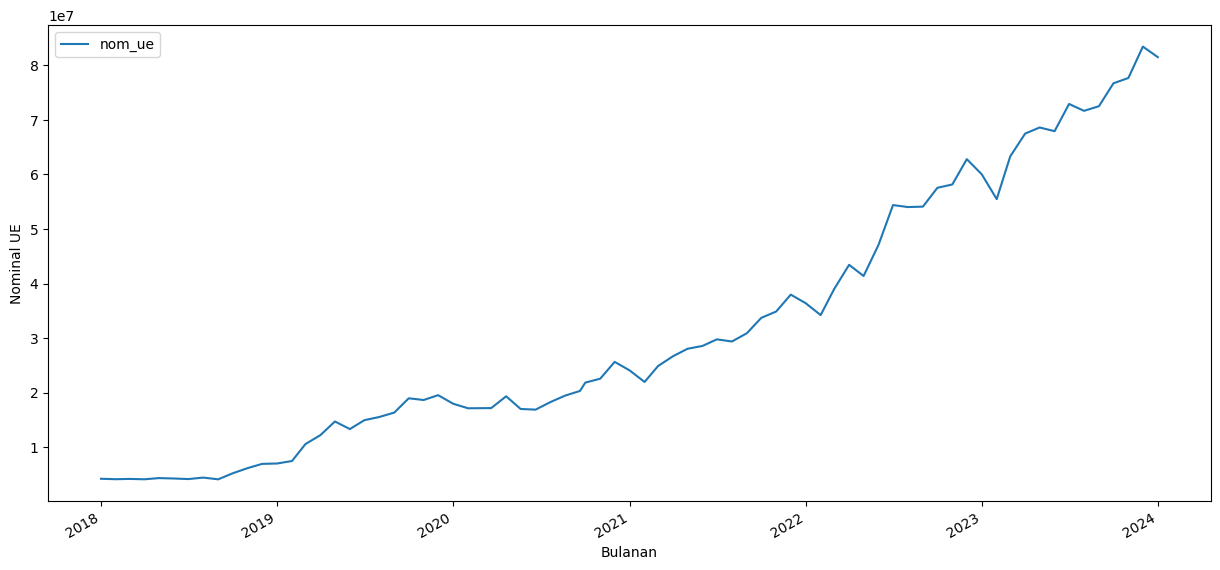

In [5]:
data_ue_all.iloc[120:-4].plot.line(x='Bulanan', y='nom_ue', figsize=(15,7), ylabel='Nominal UE')

### ML part

In [6]:
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, LassoLars, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

In [7]:

def quartal_data(dff):
    dff = dff.iloc[:-2]
    dff['Bulanan'] = pd.to_datetime(dff['Bulanan'])
    df_resampled = dff.resample('Q', on='Bulanan').sum()
    return df_resampled.reset_index()

def feature_engineer(data, period):
    # Feature engineering
    data['Bulanan'] = pd.to_datetime(data['Bulanan'])
    data = data.set_index('Bulanan', inplace=True)

    # Ensure the data is at monthly frequency (if not already)
    data['month'] = data.index.month
    data['year'] = data.index.year

    # Perform STL Decomposition
    stl = STL(data['y_variable'], seasonal=13)
    result = stl.fit()

    # Extract components
    data['trend'] = result.trend
    data['seasonal'] = result.seasonal
    data['residual'] = result.resid

    # Ensure the data is at monthly frequency
    if period == 'M':
        data = data.resample('M').mean()

        # Calculate Moving Averages (3, 7, 12)
        ma_windows = [3]
        for window in ma_windows:
            data[f'moving_average_{window}'] = data['y_variable'].rolling(window=window).mean()
        # Calculate Month-over-Month (MoM) and Year-over-Year (YoY) changes
        data['mom'] = data['y_variable'].pct_change(periods=1) * 100  # MoM with period of 1 since it's monthly data
        data['yoy'] = data['y_variable'].pct_change(periods=12) * 100  # YoY with period of 12 months

        # Calculate MoM and YoY changes for each moving average
        for window in ma_windows:
            data[f'mom_ma_{window}'] = data[f'moving_average_{window}'].pct_change(periods=1) * 100
            data[f'yoy_ma_{window}'] = data[f'moving_average_{window}'].pct_change(periods=12) * 100
        # Define new dates to add
        new_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
        new_rows = pd.DataFrame(index=new_dates, columns=data.columns)
        data = pd.concat([data, new_rows])
        for feature in data.copy().drop(['month', 'year'], axis=1).columns:
            for lag in range(3, 13):
                data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    elif period == 'Q':
         # Calculate Moving Averages (3, 7, 12)
        ma_windows = [4]
        for window in ma_windows:
            data[f'moving_average_{window}'] = data['y_variable'].rolling(window=window).mean()

        # Calculate Month-over-Month (MoM) and Year-over-Year (YoY) changes
        data['qtq'] = data['y_variable'].pct_change(periods=1) * 100  # MoM with period of 1 since it's monthly data
        for window in ma_windows:
            data[f'qtq_ma_{window}'] = data[f'moving_average_{window}'].pct_change(periods=1) * 100
        # Define new dates to add
        new_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=8, freq='Q')
        new_rows = pd.DataFrame(index=new_dates, columns=data.columns)
        data = pd.concat([data, new_rows])
        for feature in data.copy().drop(['month', 'year'], axis=1).columns:
            for lag in range(8, 13):
                data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

    data_ = data.copy()
    data.dropna(inplace=True)
    return data, data_

In [8]:
def train_test_split_(data, ratio=0.8):
    # Train-test split
    train_size = int(len(data) * ratio)
    test_size = len(data) - train_size
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    return train, test, train_size, test_size

def features_and_target(data, train, test):
    # Features and target
    features = data.copy().drop(['y_variable', 'month', 'year', 'trend', 'seasonal', 'residual'], axis=1).columns
    X_train, y_train = train[features], train['y_variable']
    X_test, y_test = test[features], test['y_variable']
    return X_train, y_train, X_test, y_test

def data_scaling(y_train, y_test):
    # Scale the target variable
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
    
    return y_train_scaled, y_test_scaled

# Function to calculate RMSE and MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

def rename_y(data):
    data = data.rename(columns={'nom_ue': 'y_variable'})
    return data


In [9]:

# Load data
period_data = 'M'
start_period =  '2013'
if period_data == 'Q':
    data = data_ue_all[['Bulanan', 'nom_ue']]
    data = rename_y(data)
    data = quartal_data(data)
    # Create a directory for saving models
    model_save_path = f"saved_models_ue-nom_2013_{period_data}"
    os.makedirs(model_save_path, exist_ok=True)
elif period_data == 'M':
    if start_period == '2013':
        data = data_ue_all[['Bulanan', 'nom_ue']].iloc[36:] #from 2013
        data = rename_y(data)
        model_save_path = f"saved_models_ue-nom_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)
    elif start_period == '2018':
        data = data_ue_all[['Bulanan', 'nom_ue']].iloc[96:] #from 2018
        data = rename_y(data)
        model_save_path = f"saved_models_ue-nom_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)


# Feature engineering
data = data.set_index('Bulanan')

# Ensure the data is at monthly frequency (if not already)
data['month'] = data.index.month
data['year'] = data.index.year

# Perform STL Decomposition
stl = STL(data['y_variable'], seasonal=13)
# result = stl.fit()


# data, data_ = feature_engineer(data, period=period_data)
# train, test, train_size, test_size = train_test_split_(data)
# X_train, y_train, X_test, y_test = features_and_target(data, train, test)

ValueError: Unable to determine period from endog

In [283]:
X_train

,moving_average_3,mom,yoy,mom_ma_3,yoy_ma_3,y_variable_lag_3,y_variable_lag_4,y_variable_lag_5,y_variable_lag_6,y_variable_lag_7,...,yoy_ma_3_lag_3,yoy_ma_3_lag_4,yoy_ma_3_lag_5,yoy_ma_3_lag_6,yoy_ma_3_lag_7,yoy_ma_3_lag_8,yoy_ma_3_lag_9,yoy_ma_3_lag_10,yoy_ma_3_lag_11,yoy_ma_3_lag_12


#### ML Modeling

In [281]:
# Initialize models and hyperparameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    # 'Ridge Regression':{
    #     'model': Ridge(),
    #     'params': {
    #         'model__alpha': [1, 10, 100],
    #         'model__max_iter': [1000, 15000]
    #     }
    # },
    'SGD Regression': {
        'model': SGDRegressor(),
        'params': {
            'model__loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
        }
    },
    'Elastic Net': {
        'model': ElasticNet(),
        'params': {
            'model__l1_ratio': [0.1, 0.25, 0.5, 1],
            'model__max_iter': [1000, 2000, 10000]
        }
    },
    # 'Lasso Lars': {
    #     'model': LassoLars(),
    #     'params': {
    #         'model__max_iter': [500, 1000, 2000]
    #     }
    # },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'model__splitter': ['best', 'random'],
            'model__max_depth': [1, 3, 5, 7, 9]
        }
    },
    'KNN':{
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [1, 2, 5, 10],
            'model__weights': ['uniform', 'distance'],
            'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'model__leaf_size': [30, 50, 100]
        }
    },
    # 'Lasso Regression': {
    #     'model': Lasso(),
    #     'params': {
    #         'model__max_iter': [500, 1000, 2000]
    #     }
    # },
    'Multi Layer Perceptron Regressor NN': {
        'model': MLPRegressor(),
        'params': {
            'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'model__max_iter': [10000],
            'model__hidden_layer_sizes': [10, 50, 100, 200, 1000],
            'model__solver': ['adam'],
            'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'model__early_stopping': [True],
            'model__learning_rate_init': [0.0001, 0.001, 0.01]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [50, 75, 100, 200, 1000]
        }
    },
    # 'Support Vector Regression': {
    #     'model': SVR(),
    #     'params': {
    #         'model__kernel': ['linear'],
    #         'model__C': [0.1, 1, 10],
    #         'model__gamma': ['scale', 'auto']
    #     }
    # },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__num_leaves': [31, 40, 50]
        }
    }
}

In [282]:


# Train models, perform hyperparameter tuning, and evaluate metrics
results = {}
predictions = {}
train_predictions = {}
metrics_df = pd.DataFrame(columns=['Model', 'Best Params', 'Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE'])

for name, model_info in models.items():
    pipeline = Pipeline([
        ('model', model_info['model'])
    ])
    print(name)
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Save the best model
    model_filename = os.path.join(model_save_path, f"{name.replace(' ', '_')}_best_model.pkl")
    joblib.dump(best_model, model_filename)

    # Predictions
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    predictions[name] = test_pred
    train_predictions[name] = train_pred
    
    # Calculate metrics
    train_rmse, train_mape = calculate_metrics(y_train, train_pred)
    test_rmse, test_mape = calculate_metrics(y_test, test_pred)
    
    results[name] = {
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
        'Train MAPE': train_mape, 'Test MAPE': test_mape
    }

   # Append metrics to DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
    }])], ignore_index=True)

# Calculate SHAP values and feature importance
feature_importances = {}

for name in models.keys():
    model_filename = os.path.join(model_save_path, f"{name.replace(' ', '_')}_best_model.pkl")
    best_model = joblib.load(model_filename)
    
    # SHAP values
    try:
        if name == "Random Forest" or name == "XGBoost" or name == "Decison Tree":
            explainer = shap.TreeExplainer(best_model.named_steps['model'], X_train)
        elif name == "Linear Regression":
            explainer = shap.LinearExplainer(best_model.named_steps['model'], X_train)
        elif name == "Multi Layer Perceptron Regressor NN":
            explainer = shap.DeepExplainer(best_model.named_steps['model'], X_train)
        elif name == "KNN":
            explainer = shap.KernelExplainer(best_model.named_steps['model'], X_train)
        else:
            # For other types of models
            explainer = shap.Explainer(best_model.named_steps['model'], X_train)
    except Exception as e:
        print("Error:", e)
        continue    
    # explainer = shap.Explainer(best_model.named_steps['model'], X_train, algorithm="auto")
    shap_values = explainer(X_train)
    
    # Calculate mean absolute SHAP values for each feature
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    feature_importances[name] = feature_importance

    # Plot feature importance
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f"Feature Importance for {name}")
    plt.savefig(os.path.join(model_save_path, f"{name.replace(' ', '_')}_feature_importance.png"))
    plt.close()

# Determine the most important features across all models
all_importances = np.array([importance for importance in feature_importances.values()])
mean_importance = np.mean(all_importances, axis=0)
sorted_indices = np.argsort(mean_importance)[::-1]
top_features = X_train.columns[sorted_indices][:4]  # Top 10 most important features

print("Top 5 most important features across all models:")
print(top_features)

# Re-train models using only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Re-train models and evaluate with top features
results_top = {}
metrics_df_top = pd.DataFrame(columns=['Model', 'Best Params', 'Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE'])

for name, model_info in models.items():
    pipeline = Pipeline([
        ('model', model_info['model'])
    ])
    print(name)
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_top, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Save the best model with top features
    model_filename = os.path.join(model_save_path, f"{name.replace(' ', '_')}_best_model_top_features.pkl")
    joblib.dump(best_model, model_filename)

    # Predictions with top features
    train_pred = best_model.predict(X_train_top)
    test_pred = best_model.predict(X_test_top)
    predictions[name] = test_pred
    train_predictions[name] = train_pred
    
    # Calculate metrics with top features
    train_rmse, train_mape = calculate_metrics(y_train, train_pred)
    test_rmse, test_mape = calculate_metrics(y_test, test_pred)
    
    results_top[name] = {
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
        'Train MAPE': train_mape, 'Test MAPE': test_mape
    }

    # Append metrics to DataFrame
    metrics_df_top = pd.concat([metrics_df_top, pd.DataFrame([{
        'Model': name,
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
    }])], ignore_index=True)

# Print evaluation results
for name, metrics in results.items():
    print(f"{name} - Best Params: {metrics['Best Params']}")
    print(f"{name} - Train RMSE: {metrics['Train RMSE']:.4f}, Test RMSE: {metrics['Test RMSE']:.4f}")
    print(f"{name} - Train MAPE: {metrics['Train MAPE']:.4f}, Test MAPE: {metrics['Test MAPE']:.4f}")

# Plot predictions
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(15, len(models) * 5))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.5)

for ax, (name, pred), (t_name, t_pred) in zip(axes, predictions.items(), train_predictions.items()):
    ax.plot(test.index, y_test, label='Actual', color='black')
    ax.plot(test.index, pred, label=f'Out-Sample {name}', linestyle='--')
    ax.plot(train.index, y_train, color='black')
    ax.plot(train.index, t_pred, label=f'In-Sample {t_name}', linestyle='--')
    ax.legend()
    ax.set_title(f'{name} Predictions vs Actual Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Nominal UE')

plt.tight_layout()
plt.show()

metrics_df['selisih MAPE'] = abs(metrics_df['Train MAPE'] - metrics_df['Test MAPE'])
metrics_df['selisih RMSE'] = abs(metrics_df['Train RMSE'] - metrics_df['Test RMSE'])

metrics_df_top['selisih MAPE'] = abs(metrics_df_top['Train MAPE'] - metrics_df_top['Test MAPE'])
metrics_df_top['selisih RMSE'] = abs(metrics_df_top['Train RMSE'] - metrics_df_top['Test RMSE'])

display(metrics_df_top.sort_values(by=['selisih RMSE', 'selisih MAPE'], ascending=True).reset_index(drop=True))

Linear Regression


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

In [259]:
importance_sum = np.sum(mean_importance)
proportions = mean_importance[sorted_indices][:5] / importance_sum

print(f"Top {len(top_features)} most important features across all models:")
for feature, proportion in zip(top_features, proportions):
    print(f"{feature}: {proportion:.2%}")

Top 4 most important features across all models:
moving_average_4: 23.27%
trend_lag_8: 20.41%
y_variable_lag_9: 13.52%
y_variable_lag_8: 12.79%


In [260]:
# display(metrics_df.sort_values(by=['selisih RMSE', 'selisih MAPE'], ascending=True).reset_index(drop=True))
display(f"Top {len(top_features)} most important features across all models:{top_features}")
display(metrics_df_top.sort_values(by=['selisih RMSE', 'selisih MAPE'], ascending=True).reset_index(drop=True))

"Top 4 most important features across all models:Index(['moving_average_4', 'trend_lag_8', 'y_variable_lag_9',\n       'y_variable_lag_8'],\n      dtype='object')"

,Model,Best Params,Train RMSE,Test RMSE,Train MAPE,Test MAPE,selisih MAPE,selisih RMSE
0,Linear Regression,{},3282594.651113,10789578.950806,0.576907,0.058322,0.518585,7506984.299693
1,Elastic Net,"{'model__l1_ratio': 1, 'model__max_iter': 2000}",3282594.651113,10789579.474290,0.576907,0.058322,0.518585,7506984.823177
2,Multi Layer Perceptron Regressor NN,"{'model__activation': 'identity', 'model__earl...",15393278.134056,104313389.423863,0.449363,0.553256,0.103892,88920111.289807
3,Decision Tree,"{'model__criterion': 'friedman_mse', 'model__m...",117179.387807,100470798.773835,0.062280,0.449681,0.387401,100353619.386028
4,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...",12957.568415,100480367.587667,0.006621,0.449748,0.443127,100467410.019253
5,KNN,"{'model__algorithm': 'auto', 'model__leaf_size...",0.000000,100470798.773835,0.000000,0.449681,0.449681,100470798.773835
6,Random Forest,{'model__n_estimators': 75},1423427.277300,103622311.433643,0.065573,0.471571,0.405998,102198884.156343
7,LightGBM,"{'model__learning_rate': 0.01, 'model__n_estim...",27007542.287705,166206934.357684,12.071926,0.883374,11.188552,139199392.069979
8,SGD Regression,"{'model__alpha': 0.0001, 'model__loss': 'huber...",141209426465.744202,840554876666.211060,4120.403208,4524.141981,403.738773,699345450200.466797


In [261]:
test_df = pd.DataFrame()
for name, pred in predictions.items():
    test_df[name] = pred

test_df = test_df.set_index(y_test.index)
test_df['actual'] = y_test
test_df.iloc[-1]

Linear Regression                         248382424.393186
SGD Regression                        1191478299972.292236
Elastic Net                               248382419.695996
Decision Tree                              90095355.017096
KNN                                        90095355.017096
Multi Layer Perceptron Regressor NN       413266244.784559
Random Forest                              86511692.159601
XGBoost                                    90084424.000000
LightGBM                                   19093465.638622
actual                                    253394822.528615
Name: 2024-03-31 00:00:00, dtype: float64

In [262]:
data_[-8:][top_features]

,moving_average_4,trend_lag_8,y_variable_lag_9,y_variable_lag_8
2024-06-30,NaN,136352445.207502,109657614.810586,131955149.297558
2024-09-30,NaN,154803691.490841,131955149.297558,162529858.980938
2024-12-31,NaN,172327162.924608,162529858.980938,178529727.486001
2025-03-31,NaN,187666126.533092,178529727.486001,178822993.876677
2025-06-30,NaN,201927628.098935,178822993.876677,204033304.592322
2025-09-30,NaN,219245540.458188,204033304.592322,217086260.693633
2025-12-31,NaN,237070586.721662,217086260.693633,237813123.629760
2026-03-31,NaN,255077298.048436,237813123.629760,253394822.528615


In [ ]:
model_save_path = 'saved_models_ue-vol_2013_Q'


In [104]:
# Path to the directory where models are saved
model_save_path = "saved_models_ue-nom_2018"

# Load models into a dictionary
loaded_models = {}
for model_name in os.listdir(model_save_path):
    model_path = os.path.join(model_save_path, model_name)
    model_key = model_name.replace('_best_model_top_features.pkl', '').replace('_', ' ')
    loaded_models[model_key] = joblib.load(model_path)

# Sample new data (replace with your actual new data)
X_forecast = full_data[features][-3:]
# Dictionary to store predictions
next_predictions = {}

# Predict next 3 values using each loaded model
for model_name, model in loaded_models.items():
    predictions = model.predict(X_forecast)
    next_predictions[model_name] = predictions
    print(f"Predictions for {model_name}: {predictions}")

# Convert predictions to DataFrame for better readability
predictions_df = pd.DataFrame(next_predictions, index=X_forecast.index)
# predictions_df['Actual Value'] = '94046551734753.0'
display(predictions_df)

result_fc = predictions_df.loc[:'2024-05-31'].T
result_fc['Actual Value'] = '94,046,551.74'
display(result_fc)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- mom
- mom_lag_10
- mom_lag_11
- mom_lag_12
- mom_lag_3
- ...


### TS Part

In [172]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from prophet import Prophet
from pytorch_forecasting import DeepAR, TimeSeriesDataSet
# from gluonts.mx import DeepAREstimator
from pmdarima import auto_arima
from pmdarima import model_selection 
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#### Prophet

In [195]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

fb_train = train.reset_index().rename(columns={"y_variable":"y",'Bulanan':'ds'})
# fb_train_ = data.reset_index().rename(columns={"nom_ue":"y",'Bulanan':'ds'})


In [186]:

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fb_train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='3 MS',  parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmpaigwy_qc\lr2d2a_3.json
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmpaigwy_qc\ruc5clgz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\arnanda_p.i\\AppData\\Roaming\\Python\\Python39\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=57127', 'data', 'file=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmpaigwy_qc\\lr2d2a_3.json', 'init=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmpaig

    changepoint_prior_scale  seasonality_prior_scale            rmse
0                  0.001000                 0.010000 16388853.863018
1                  0.001000                 0.100000 17305618.681503
2                  0.001000                 1.000000 17816850.456053
3                  0.001000                10.000000 18311002.522663
4                  0.010000                 0.010000 16786218.917289
5                  0.010000                 0.100000 17371131.921852
6                  0.010000                 1.000000 17965105.758080
7                  0.010000                10.000000 18327245.283547
8                  0.100000                 0.010000  9272850.265463
9                  0.100000                 0.100000  9224945.421535
10                 0.100000                 1.000000  7591605.559437
11                 0.100000                10.000000  9158718.235862
12                 0.500000                 0.010000  5232032.768571
13                 0.500000       

In [196]:
fb_model = Prophet(**all_params[np.argmin(rmses)])
fb_model.fit(fb_train)
# fb_model.fit(fb_train_)

if period_data == 'M':
    future_dates = fb_model.make_future_dataframe(periods=test_size, freq='MS')
elif period_data == 'Q':
    future_dates = fb_model.make_future_dataframe(periods=test_size, freq='QS')
# future_dates_ = fb_model.make_future_dataframe(periods=3, freq='MS')
forecast = fb_model.predict(future_dates)
# forecast_ = fb_model.predict(future_dates_)

print(all_params[np.argmin(rmses)])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmpaigwy_qc\pa0yezwl.json
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmpaigwy_qc\z4bh6yop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\arnanda_p.i\\AppData\\Roaming\\Python\\Python39\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=30900', 'data', 'file=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmpaigwy_qc\\pa0yezwl.json', 'init=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmpaigwy_qc\\z4bh6yop.json', 'output', 'file=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmpaigwy_qc\\prophet_model3vv1s0ea

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


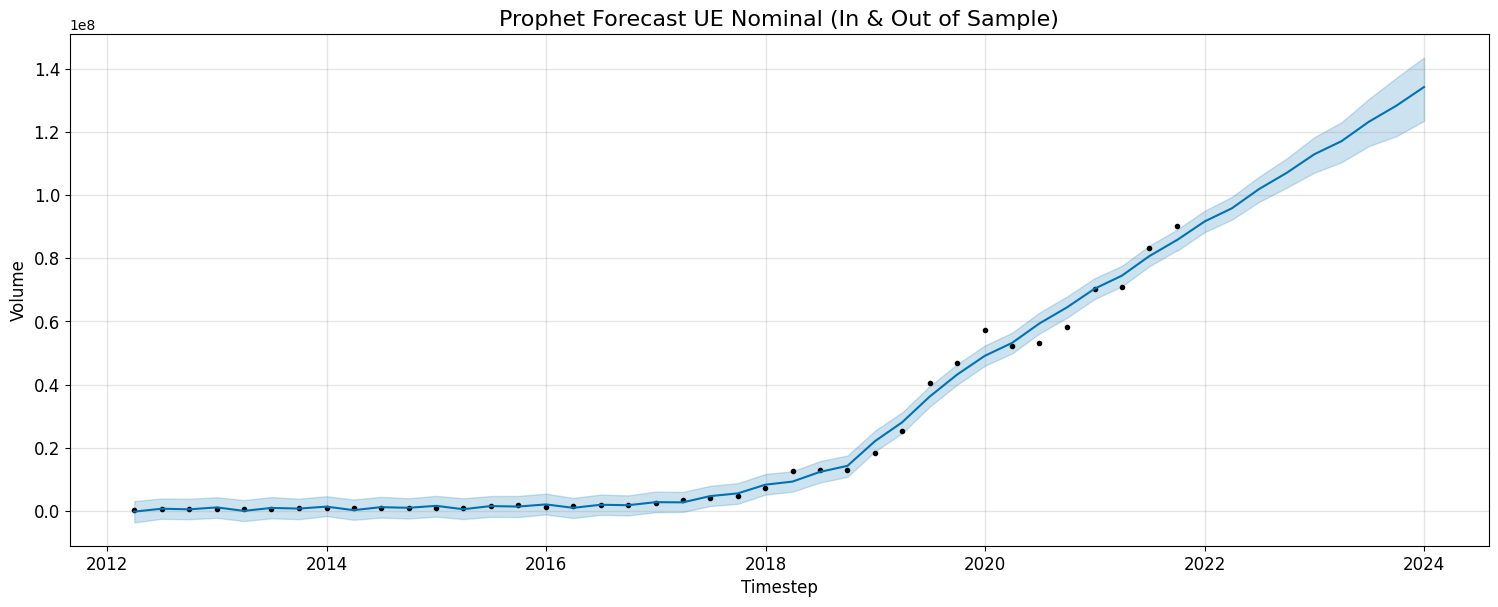

In [197]:
fig = fb_model.plot(forecast, uncertainty=True, figsize=(15,6))
ax = fig.gca()
ax.set_title("Prophet Forecast UE Nominal (In & Out of Sample)", size=16)
ax.set_xlabel("Timestep", size=12)
ax.set_ylabel("Volume", size=12)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

In [198]:
train_rmse, train_mape = calculate_metrics(data['y_variable'].iloc[:train_size], forecast['yhat'].iloc[:train_size])
test_rmse, test_mape = calculate_metrics(data['y_variable'].iloc[train_size:], forecast['yhat'].iloc[train_size:])

# Append metrics to DataFrame
fb_metrics = pd.DataFrame([{
    'Model': 'Prophet',
    'Best Params': all_params[np.argmin(rmses)],
    'Train RMSE': train_rmse,
    'Test RMSE': test_rmse,
    'Train MAPE': train_mape,
    'Test MAPE': test_mape
}])

display(fb_metrics)

,Model,Best Params,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,Prophet,"{'changepoint_prior_scale': 0.5, 'seasonality_...",2564762.265325,75981618.480918,0.291083,0.356395


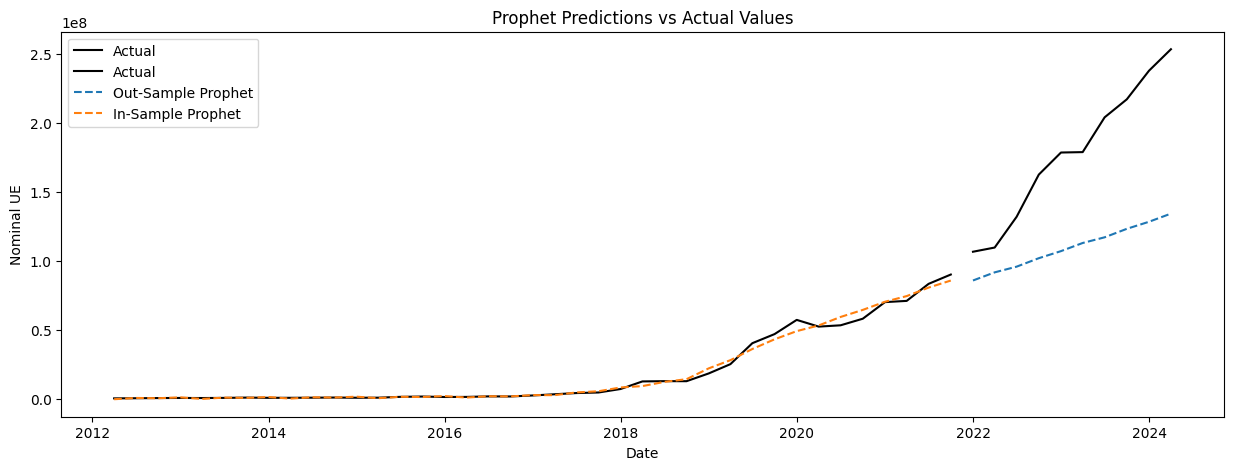

In [199]:
# Plot predictions
plt.figure(figsize=(15, 5))
plt.plot(data.iloc[train_size:].index, data['y_variable'].iloc[train_size:], label='Actual', color='black')
plt.plot(data.iloc[:train_size].index, data['y_variable'].iloc[:train_size], label='Actual', color='black')
plt.plot(data.iloc[train_size:].index, forecast['yhat'].iloc[train_size:], label=f'Out-Sample Prophet', linestyle='--')
plt.plot(data.iloc[:train_size].index, forecast['yhat'].iloc[:train_size], label=f'In-Sample Prophet', linestyle='--')
plt.legend()
plt.title('Prophet Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Nominal UE')

plt.show()

In [86]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(fb_model))  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-03-31,393101.350150,-3713440.102163,3056767.998175,393101.350150,393101.350150,-668130.579308,-668130.579308,-668130.579308,-668130.579308,-668130.579308,-668130.579308,0.000000,0.000000,0.000000,-275029.229158
1,2012-06-30,451380.950778,-2556712.015068,3893837.143637,451380.950778,451380.950778,188534.176461,188534.176461,188534.176461,188534.176461,188534.176461,188534.176461,0.000000,0.000000,0.000000,639915.127239
2,2012-09-30,510301.088285,-2690498.776713,3785513.758864,510301.088285,510301.088285,-61350.225104,-61350.225104,-61350.225104,-61350.225104,-61350.225104,-61350.225104,0.000000,0.000000,0.000000,448950.863181
3,2012-12-31,569221.169448,-2245840.361890,4284949.094594,569221.169448,569221.169448,490212.225202,490212.225202,490212.225202,490212.225202,490212.225202,490212.225202,0.000000,0.000000,0.000000,1059433.394651
4,2013-03-31,626860.379282,-3265473.542908,3377078.017794,626860.379282,626860.379282,-670145.420864,-670145.420864,-670145.420864,-670145.420864,-670145.420864,-670145.420864,0.000000,0.000000,0.000000,-43285.041582
5,2013-06-30,685140.003095,-2403881.794417,4338191.881367,685140.003095,685140.003095,199702.965756,199702.965756,199702.965756,199702.965756,199702.965756,199702.965756,0.000000,0.000000,0.000000,884842.968852
6,2013-09-30,744060.204555,-2665975.658983,3829518.693480,744060.204555,744060.204555,-54818.314642,-54818.314642,-54818.314642,-54818.314642,-54818.314642,-54818.314642,0.000000,0.000000,0.000000,689241.889913
7,2013-12-31,803282.884110,-1709009.017374,4604880.779299,803282.884110,803282.884110,502163.455821,502163.455821,502163.455821,502163.455821,502163.455821,502163.455821,0.000000,0.000000,0.000000,1305446.339931
8,2014-03-31,861804.123899,-2854267.288506,3561905.469938,861804.123899,861804.123899,-671678.034270,-671678.034270,-671678.034270,-671678.034270,-671678.034270,-671678.034270,0.000000,0.000000,0.000000,190126.089629
9,2014-06-30,921712.641872,-2170140.028656,4402183.537612,921712.641872,921712.641872,210616.561268,210616.561268,210616.561268,210616.561268,210616.561268,210616.561268,0.000000,0.000000,0.000000,1132329.203141


#### AutoARIMA

In [178]:
autoArima = pm.auto_arima(train['y_variable'], start_p=1, start_q=1,
                         test='kpss',
                         max_p=10, max_q=10, 
                         m=12, 
                         start_P=0, 
                         seasonal=True,
                         d=None, 
                         D=1, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,
                         cv=TimeSeriesSplit(n_splits=5))

autoArima_ = pm.auto_arima(data['y_variable'], start_p=1, start_q=1,
                         test='kpss',
                         max_p=10, max_q=10, 
                         m=12, 
                         start_P=0, 
                         seasonal=True,
                         d=None, 
                         D=1, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,
                         cv=TimeSeriesSplit(n_splits=5))

# cv = model_selection.SlidingWindowForecastCV(window_size=10, step=3, h=3)
# cv_pred = model_selection.cross_val_predict(autoArima, train['nom_ue'], cv=cv, verbose=2, averaging="median")
fc, confint = autoArima.predict(n_periods=test.shape[0], return_conf_int=True)
# fc, confint = autoArima_.predict(n_periods=3, return_conf_int=True)
arima_train_pred = autoArima.predict_in_sample()
index_of_fc = np.arange(len(train['y_variable']), len(train['y_variable'])+test.shape[0])
# date_range = np.arange(len(data['nom_ue']), len(data['nom_ue'])+3)
# pd.date_range(start=data.index[-1]+pd.DateOffset(months=1), periods=3, freq='M')


# cv_series = pd.Series(cv_pred, index=test.index)
fc_series = pd.Series(fc)
# fc_series_ = pd.Series(fc, index=date_range)
# train_series = pd.Series(train_pred, index=train.index)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [179]:
fc

2021-12-31   100481393.135960
2022-03-31   111980319.577857
2022-06-30   131922692.378072
2022-09-30   143252188.045883
2022-12-31   158312108.473295
2023-03-31   158178867.931856
2023-06-30   163869714.587827
2023-09-30   173380249.466627
2023-12-31   190146936.725920
2024-03-31   195762312.434042
Freq: QE-DEC, dtype: float64

In [181]:
# Print the best parameters
print(f"Best ARIMA order: {autoArima.order}")
print(f"Best seasonal order: {autoArima.seasonal_order}")
print(f"Best AIC: {autoArima.aic()}")

display(test['y_variable'])
display(fc_series)
display(arima_train_pred)

Best ARIMA order: (1, 1, 1)
Best seasonal order: (0, 1, 0, 12)
Best AIC: 881.4450222656934


Bulanan
2021-12-31   106621045.611930
2022-03-31   109657614.810586
2022-06-30   131955149.297558
2022-09-30   162529858.980938
2022-12-31   178529727.486001
2023-03-31   178822993.876677
2023-06-30   204033304.592322
2023-09-30   217086260.693633
2023-12-31   237813123.629760
2024-03-31   253394822.528615
Name: y_variable, dtype: float64

2021-12-31   100481393.135960
2022-03-31   111980319.577857
2022-06-30   131922692.378072
2022-09-30   143252188.045883
2022-12-31   158312108.473295
2023-03-31   158178867.931856
2023-06-30   163869714.587827
2023-09-30   173380249.466627
2023-12-31   190146936.725920
2024-03-31   195762312.434042
Freq: QE-DEC, dtype: float64

2012-03-31          0.000000
2012-06-30     656151.687189
2012-09-30     649718.142496
2012-12-31     745355.559520
2013-03-31     799672.643364
2013-06-30     691355.517120
2013-09-30     787560.239404
2013-12-31    1023253.767214
2014-03-31     810475.849993
2014-06-30     810629.433049
2014-09-30     899489.947672
2014-12-31    1013752.187206
2015-03-31    1168216.902213
2015-06-30     923147.711081
2015-09-30    1627890.182020
2015-12-31    1818799.401707
2016-03-31    1278968.757225
2016-06-30    1511112.560768
2016-09-30    2046651.500626
2016-12-31    1567495.925838
2017-03-31    2600201.228205
2017-06-30    3651611.497797
2017-09-30    4643477.317963
2017-12-31    4795987.851837
2018-03-31    7901330.936028
2018-06-30   14692446.735906
2018-09-30   14211402.692094
2018-12-31   13408256.950378
2019-03-31   20209587.665993
2019-06-30   28058032.542582
2019-09-30   44777024.909589
2019-12-31   52465931.517368
2020-03-31   63678603.125244
2020-06-30   57005052.428853
2020-09-30   5

In [182]:
atrain_rmse, atrain_mape = calculate_metrics(train['y_variable'], arima_train_pred)
atest_rmse, atest_mape = calculate_metrics(test['y_variable'], fc_series)

# Append metrics to DataFrame
a_metrics = pd.DataFrame([{
    'Model': 'Auto ARIMA',
    'Train RMSE': atrain_rmse,
    'Test RMSE': atest_rmse,
    'Train MAPE': atrain_mape,
    'Test MAPE': atest_mape
}])

display(a_metrics)

,Model,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,Auto ARIMA,3974360.158506,32197131.809898,0.202505,0.125237


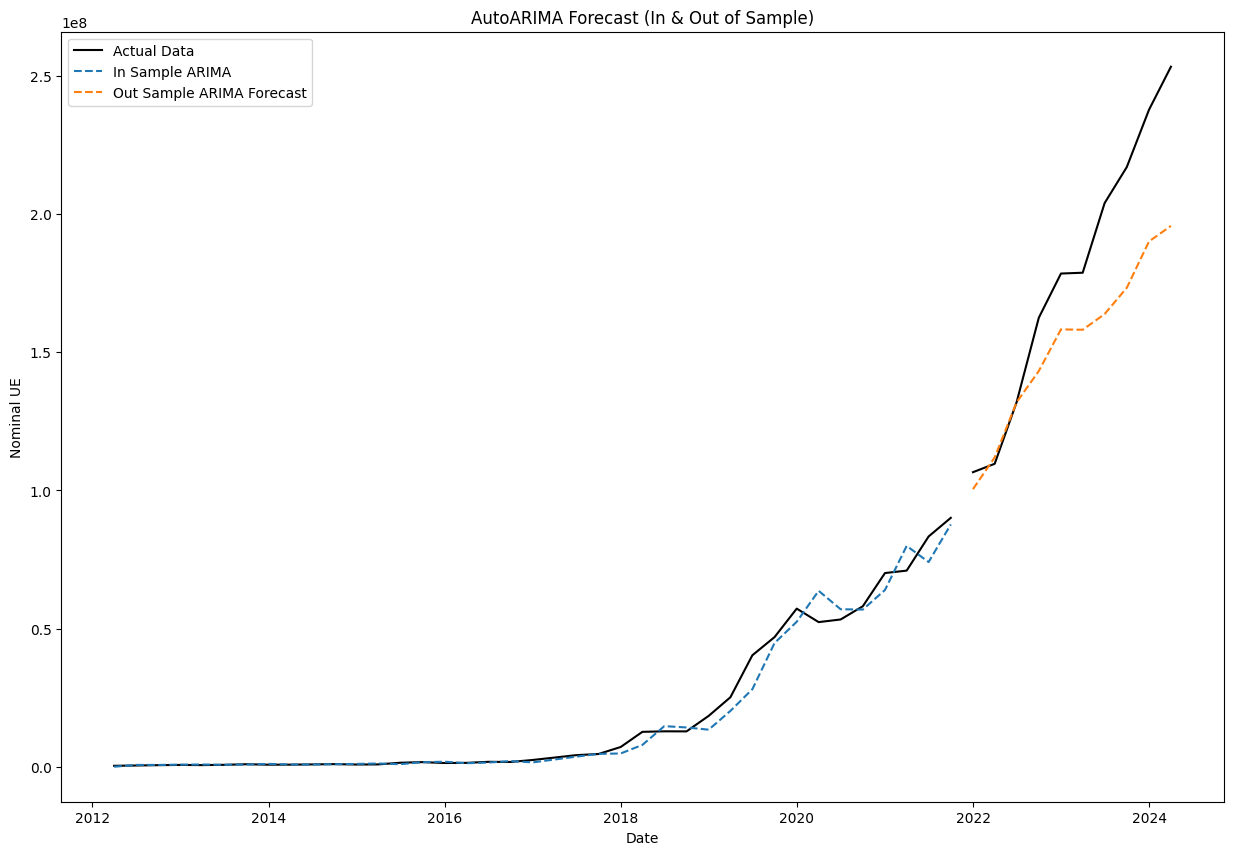

In [183]:
plt.figure(figsize=(15,10))
plt.plot(train.index, train['y_variable'], label='Actual Data', color='black')
plt.plot(train.index, arima_train_pred, label='In Sample ARIMA', linestyle='--')
plt.plot(test.index, test['y_variable'], color='black')
plt.plot(test.index, fc_series, label='Out Sample ARIMA Forecast', linestyle='--')
plt.legend()
plt.title("AutoARIMA Forecast (In & Out of Sample)")
plt.xlabel('Date')
plt.ylabel('Nominal UE')
plt.show()

#### Seasonal Trend

In [173]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [174]:
# Decompose the time series using STL
stl = STL(data['y_variable'], seasonal=13, period=12)
result = stl.fit()

# Extract the seasonal, trend, and residual components
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Deseasonalize the data
deseasonalized = data['y_variable'] - seasonal

# Split deseasonalized data into train and test sets
train_size = int(len(deseasonalized) * 0.8)
train_deseasonalized, test_deseasonalized = deseasonalized[:train_size], deseasonalized[train_size:]

# Fit an Exponential Smoothing model on the deseasonalized data
model = ExponentialSmoothing(train_deseasonalized, trend='add', seasonal=None)
fitted_model = model.fit()

# Forecast the deseasonalized data
# deseasonalized_forecast = fitted_model.forecast(steps=len(test_deseasonalized))

# Reconstruct the forecasted values by adding the seasonal component back
# forecast_with_seasonality = deseasonalized_forecast + seasonal[-len(test_deseasonalized):].values

# Forecast future values beyond the test set
future_steps = len(test_deseasonalized) + 3 # Example: forecast 12 periods into the future
future_deseasonalized_forecast = fitted_model.forecast(steps=future_steps)
future_seasonal_component = np.tile(seasonal[:future_steps], future_steps // len(seasonal) + 1)[:future_steps]
future_forecast = future_deseasonalized_forecast + future_seasonal_component




C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [175]:
stl_train_rmse, stl_train_mape = calculate_metrics(data['y_variable'].loc[train_deseasonalized.index], fitted_model.fittedvalues + seasonal[:len(fitted_model.fittedvalues)])
stl_test_rmse, stl_test_mape = calculate_metrics(data['y_variable'].loc[test_deseasonalized.index], future_forecast[:-3])

# Append metrics to DataFrame
stl_metrics = pd.DataFrame([{
    'Model': 'Seasonal Trend',
    'Train RMSE': stl_train_rmse,
    'Test RMSE': stl_test_rmse,
    'Train MAPE': stl_train_mape,
    'Test MAPE': stl_test_mape
}])

display(stl_metrics)

,Model,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,Seasonal Trend,4610625.111937,19066468.304117,1.608191,0.089396


C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_31592\2034835268.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


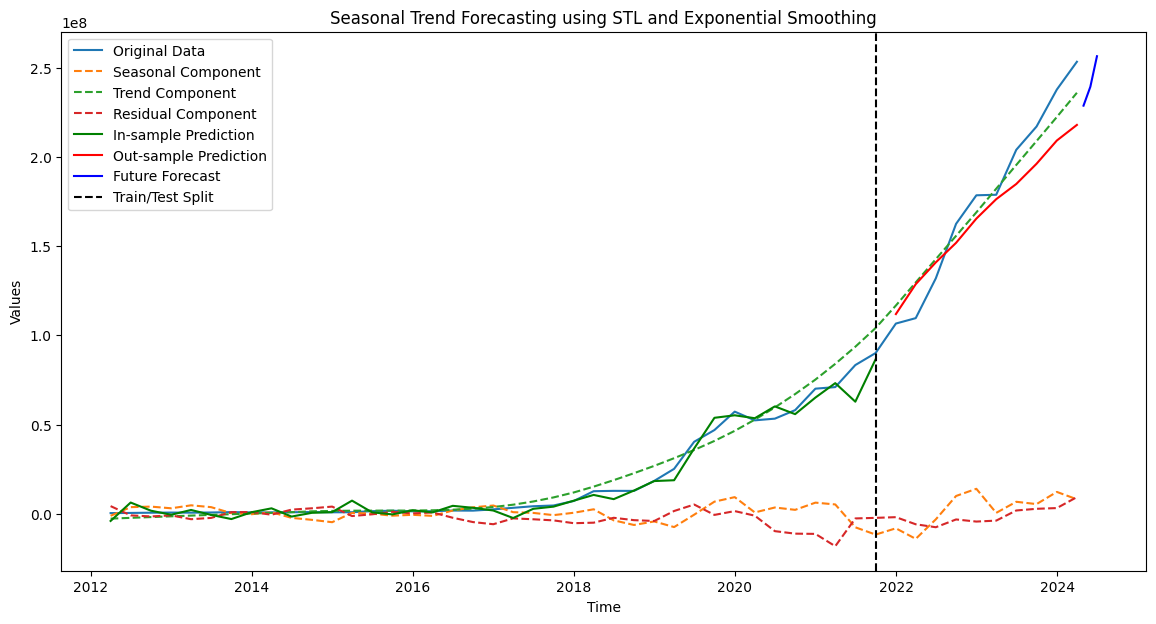

In [176]:
# Visualize the results
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(data['y_variable'], label='Original Data')
# Plot seasonal, trend, and residual components
plt.plot(seasonal, label='Seasonal Component', linestyle='--')
plt.plot(trend, label='Trend Component', linestyle='--')
plt.plot(residual, label='Residual Component', linestyle='--')
# Plot in-sample predictions
plt.plot(train_deseasonalized.index, fitted_model.fittedvalues + seasonal[:len(fitted_model.fittedvalues)], label='In-sample Prediction', color='green')
# Plot out-sample predictions
plt.plot(test_deseasonalized.index, future_forecast[:-3], label='Out-sample Prediction', color='red')
# Plot future predictions
future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
plt.plot(future_index, future_forecast[-3:], label='Future Forecast', color='blue')
plt.axvline(x=train_deseasonalized.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('Seasonal Trend Forecasting using STL and Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

In [177]:
future_forecast

2021-12-31   111933377.159627
2022-03-31   128701068.470814
2022-06-30   140910299.435073
2022-09-30   151882549.569503
2022-12-31   165460323.162643
2023-03-31   176344777.877625
2023-06-30   184864632.916524
2023-09-30   196208562.555871
2023-12-31   209234632.488481
2024-03-31   217984782.465301
2024-06-30   228785548.424862
2024-09-30   239374728.809879
2024-12-31   256501987.499872
Freq: QE-DEC, dtype: float64

#### GluonTS

In [201]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer, DeepAREstimator, MQCNNEstimator, TransformerEstimator
from gluonts.model.npts import NPTSPredictor
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions, backtest_metrics
from gluonts.evaluation import Evaluator
import json

In [205]:
def create_dataset_gluonts(data, train, test, period_data):
    train_ = ListDataset(
        [{"target": train['y_variable'].values, "start": train.index[0]}],
        freq=period_data,
    )

    test_ = ListDataset(
        [{"target": data['y_variable'].values, "start": data.index[0]}],
        freq=period_data,
    )

    eval_ = ListDataset(
        [{"target": test['y_variable'].values, "start": test.index[0]}],
        freq=period_data,
    )

    return test_, train_, eval_

def estimators(test_size, algorithm_name, epoch):
    if algorithm_name == 'Simple Feed Forward':
        SFF_estimator = SimpleFeedForwardEstimator(
            num_hidden_dimensions=[10],
            prediction_length=test_size,
            context_length=100,
            trainer=Trainer(ctx="cpu", epochs=epoch, learning_rate=1e-3, num_batches_per_epoch=100),
        )
        return SFF_estimator
    
    elif algorithm_name == 'DeepAR':
        DR_estimator = DeepAREstimator(
            freq='M',
            prediction_length=test_size,
            trainer=Trainer(ctx="cpu", epochs=epoch, learning_rate=1e-3, num_batches_per_epoch=100)
        )
        return DR_estimator
    
    elif algorithm_name == 'Transformer':
        T_estimator = TransformerEstimator(
            freq='M',
            prediction_length=test_size,
            trainer=Trainer(ctx="cpu", epochs=epoch, learning_rate=1e-3, num_batches_per_epoch=100)
        )
        return T_estimator
    
def gluonts_training(train_, the_estimator):
    the_predictor = the_estimator.train(train_)
    return the_predictor

def gluonts_forecast(the_predictor, train_, test_):
    is_forecast = list(the_predictor.predict(train_))
    os_forecast = list(the_predictor.predict(test_))
    return is_forecast, os_forecast

def gluonts_predict(train_, the_predictor):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=train_,  # test dataset
        predictor=the_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    return list(forecast_it), list(ts_it)

In [84]:
test_, train_, eval_  = create_dataset_gluonts(data, train, test)
DR_estimator = estimators(test_size, algorithm_name='DeepAR')
DR_predictor = gluonts_training(train_, the_estimator=DR_estimator)
test_forecast, out_forecast = gluonts_forecast(DR_predictor, train_, test_)
train_predict, ts_ = gluonts_predict(train_, DR_predictor)

C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\dataset\common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\time_feature\lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\time_feature\_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
100%|██████████| 100/100 [00:03<00:00, 27.31it/s, epoch=1/1, avg_epoch_loss=16.8]


In [208]:
def deepar_metrics(train, test, test_forecast, train_predict, test_size):
    dr_test_pred = pd.Series(test_forecast[0].mean, index=test_forecast[0].index)
    dr_train_pred = pd.Series(train_predict[0].mean, index=train_predict[0].index)
    dtrain_rmse, dtrain_mape = calculate_metrics(train['y_variable'][-test_size:], dr_train_pred)
    dtest_rmse, dtest_mape = calculate_metrics(test['y_variable'], dr_test_pred)

    # Append metrics to DataFrame
    dr_metrics = pd.DataFrame([{
        'Model': 'DeepAR',
        'Train RMSE': dtrain_rmse,
        'Test RMSE': dtest_rmse,
        'Train MAPE': dtrain_mape,
        'Test MAPE': dtest_mape
    }])

    return dr_metrics



In [207]:
def plot_deepar(data, test_forecast, train_predict):
    plt.figure(figsize=(14,7))
    plt.plot(data.iloc[train_size:].index, data['y_variable'].iloc[train_size:], color='black')
    plt.plot(data.iloc[:train_size].index, data['y_variable'].iloc[:train_size], label='Actual', color='black')
    test_forecast[0].plot(show_label=True, intervals=(0.0, 0.9))
    train_predict[0].plot(show_label=True)
    plt.legend()
    plt.title("DeepAR Forecast (In & Out of Sample)")
    plt.xlabel('Date')
    plt.ylabel('Nominal UE')
    plt.show()

C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_31592\2408788853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Bulanan'] = pd.to_datetime(dff['Bulanan'])
C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_31592\2408788853.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_resampled = dff.resample('Q', on='Bulanan').sum()
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\dataset\common.py:255: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\time_feature\lag.py:10

,Model,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,DeepAR,1982924.983875,51404504.722733,0.032609,0.287678


2021Q4    73382592.000000
2022Q1    73034888.000000
2022Q2    88661840.000000
2022Q3   110480792.000000
2022Q4   107878792.000000
2023Q1   120504944.000000
2023Q2   135290832.000000
2023Q3   152427664.000000
2023Q4   193047792.000000
2024Q1   262989088.000000
Freq: Q-DEC, dtype: float32

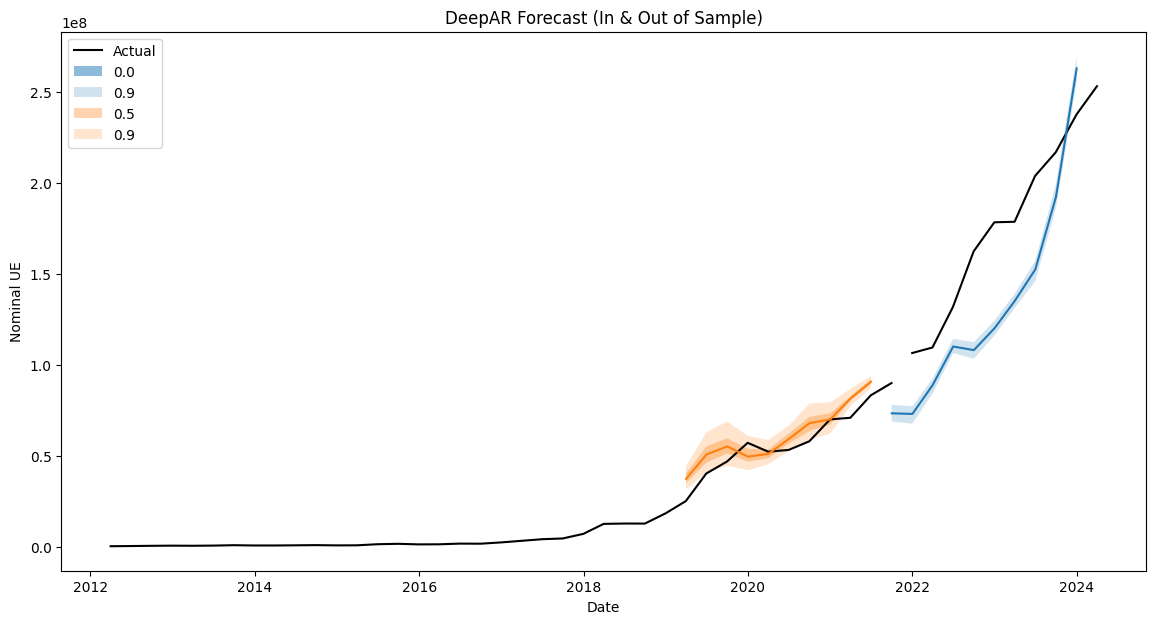

In [215]:
data2013 = data_ue_all[['Bulanan', 'nom_ue']].iloc[36:] #from 2013
data2018 = data_ue_all[['Bulanan', 'nom_ue']].iloc[96:] #from 2018

list_data = [data2013, data2018]

# Load data
period_data = 'Q'
start_period =  '2013'
if period_data == 'Q':
    data = data_ue_all[['Bulanan', 'nom_ue']]
    # Create a directory for saving models
    model_save_path = f"saved_models_ue-nom_2013_{period_data}"
    os.makedirs(model_save_path, exist_ok=True)
elif period_data == 'M':
    if start_period == '2013':
        data = data_ue_all[['Bulanan', 'nom_ue']].iloc[36:] #from 2013
        model_save_path = f"saved_models_ue-nom_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)
    elif start_period == '2018':
        data = data_ue_all[['Bulanan', 'nom_ue']].iloc[96:] #from 2018
        model_save_path = f"saved_models_ue-nom_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)

data = rename_y(data)
data = quartal_data(data)

data = feature_engineer(data, period=period_data)
train, test, train_size, test_size = train_test_split_(data)
X_train, y_train, X_test, y_test = features_and_target(data, train, test)

test_, train_, eval_  = create_dataset_gluonts(data, train, test, period_data=period_data)
DR_estimator = estimators(test_size, algorithm_name='DeepAR', epoch=100)
DR_predictor = gluonts_training(train_, the_estimator=DR_estimator)
test_forecast, out_forecast = gluonts_forecast(DR_predictor, train_, test_)
train_predict, ts_ = gluonts_predict(train_, DR_predictor)

dr_test_pred = pd.Series(test_forecast[0].mean, index=test_forecast[0].index)
dr_test_pred.to_csv(f"UE-Nominal_DeepAR-forecasting_periode-triwulanan.csv")
display(deepar_metrics(train, test, test_forecast, train_predict, test_size))
display(dr_test_pred)
plot_deepar(data, test_forecast, train_predict)


# for x, data in zip([2013, 2018], list_data):
#     print(f"data dari tahun {x}")
#     data = feature_engineer(data, period=period_data)
#     train, test, train_size, test_size = train_test_split_(data)
#     X_train, y_train, X_test, y_test = features_and_target(data, train, test)

#     test_, train_, eval_  = create_dataset_gluonts(data, train, test)
#     DR_estimator = estimators(test_size, algorithm_name='DeepAR', epoch=100)
#     DR_predictor = gluonts_training(train_, the_estimator=DR_estimator)
#     test_forecast, out_forecast = gluonts_forecast(DR_predictor, train_, test_)
#     train_predict, ts_ = gluonts_predict(train_, DR_predictor)

#     dr_test_pred = pd.Series(test_forecast[0].mean, index=test_forecast[0].index)
#     dr_test_pred.to_csv(f"UE-Nominal_DeepAR-forecasting_periode-{x}.csv")
#     display(deepar_metrics(train, test, test_forecast, train_predict, test_size))
#     display(dr_test_pred)
#     plot_deepar(data, test_forecast, train_predict)

In [73]:
ts_forecast_df = forecast_[-3:][['ds','yhat']]
ts_forecast_df = ts_forecast_df.set_index('ds')
ts_forecast_df['AutoARIMA'] = fc
ts_forecast_df['Seasonal Trend'] = future_forecast[-3:]
# ts_forecast_df['DeepAR'] = dr_os_forecast[0].mean
ts_forecast_df = ts_forecast_df.rename(columns={'ds': 'Date', 'yhat':'Prophet'})

# tsfc_df = ts_forecast_df.T
# tsfc_df['Actual Value'] = '94,046,551.74'
# display(tsfc_df)
ts_forecast_df

,Prophet,AutoARIMA,Seasonal Trend
ds,,,
2024-05-01,90152706.083300,NaN,NaN
2024-06-01,90878445.984266,NaN,NaN
2024-07-01,92142094.417322,NaN,NaN


#### try TS Models

In [134]:
# Define models
models = {
    'AutoARIMA': {
        'model': None  # Placeholder for the fitted model
    },
    'Prophet': {
        'model': None  # Placeholder for the fitted model
    },
    'DeepAR': {
        'model': None  # Placeholder for the fitted model
    },
    # 'Simple Feed Forward': {
    #     'model': None  # Placeholder for the fitted model
    # },
    # 'Transformer': {
    #     'model': None  # Placeholder for the fitted model
    # },
    'Seasonal Trend': {
        'model': None  # Placeholder for the fitted model
    },
    'NPTS': {
        'model': None  # Placeholder for the fitted model
    }
}

# Train models
for name, model_info in models.items():
    if name == 'AutoARIMA':
        # Fit AutoARIMA
        model_info['model'] = auto_arima(train['nom_ue'], seasonal=True, m=12)
    elif name == 'Prophet':
        # Fit Prophet
        model = Prophet()
        model.fit(train.reset_index().rename(columns={'Bulanan': 'ds', 'nom_ue': 'y'}))
        model_info['model'] = model
    # elif name in ['DeepAR', 'Simple Feed Forward', 'Transformer']:
        # Fit GluonTS models
        # if name == 'DeepAR':
        #     estimator = DeepAREstimator(
        #         prediction_length=12,
        #         freq='M',
        #         trainer=Trainer(epochs=10)
        #     )
        # elif name == 'Simple Feed Forward':
        #     estimator = SimpleFeedForwardEstimator(
        #         prediction_length=12,
        #         freq='M',
        #         trainer=Trainer(epochs=10)
        #     )
        # elif name == 'Transformer':
        #     estimator = TransformerEstimator(
        #         prediction_length=12,
        #         freq='M',
        #         trainer=Trainer(epochs=10)
        #     )
        # predictor = estimator.train(train)
        # model_info['model'] = predictor
    # elif name == 'Seasonal Trend':
    #     # Fit Seasonal Trend
    #     model = STL(train, seasonal=12).fit()
    #     model_info['model'] = model
    # elif name == 'NPTS':
    #     # Fit NPTS (Naive Periodic Time Series)
    #     model = ExponentialSmoothing(train['nom_ue'], seasonal=12).fit()
    #     model_info['model'] = model

# Generate forecasts
forecasts = {}
for name, model_info in models.items():
    if name in ['AutoARIMA', 'Prophet', 'Seasonal Trend', 'NPTS']:
        forecasts[name] = model_info['model'].predict(start=test.index[0], end=test.index[-1])
    else:
        forecast_it, ts_it = model_info['model'].make_evaluation_predictions(
            dataset=test, num_samples=len(test)
        )
        forecasts[name] = list(forecast_it)

# Evaluate models
results = {}
for name, forecast in forecasts.items():
    if name in ['AutoARIMA', 'Prophet', 'Seasonal Trend', 'NPTS']:
        y_pred = forecast
    else:
        y_pred = np.concatenate([sample.mean for sample in forecast])
    rmse = np.sqrt(mean_squared_error(test['value'], y_pred))
    mape = mean_absolute_percentage_error(test['value'], y_pred)
    results[name] = {'RMSE': rmse, 'MAPE': mape}

# Print evaluation results
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.2f}, MAPE = {metrics['MAPE']:.2f}")

# Plot forecasts
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test', color='black')

for name, forecast in forecasts.items():
    if name in ['AutoARIMA', 'Prophet', 'Seasonal Trend', 'NPTS']:
        plt.plot(test.index, forecast, label=name)
    else:
        y_pred = np.concatenate([sample.mean for sample in forecast])
        plt.plot(test.index, y_pred, label=name)

plt.title('Time Series Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

23:22:17 - cmdstanpy - INFO - Chain [1] start processing
23:22:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: predict() got an unexpected keyword argument 'start'